In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [30]:
with open('search_result', 'r') as file:
    with open('filtered_result', 'w') as out:
        lock = False
        for line in file:        
            if lock:
                if line != '\n':
                    out_line=''
                    if line[9]=='|':
                        out_line = line[3:9] + ',' + line[55:61] + '\n'
                    if line[13]=='|':
                        out_line = line[3:13] + ',' + line[55:61] + '\n'
                    out.write(out_line)
                else: 
                    lock = False
            else:
                if '--------                       -----------              -----    ------- ---' in line:
                    lock = True

In [31]:
init_cols = ['Entry', 'Score']
initial = pd.read_csv('filtered_result', names=init_cols)
initial.sort_values('Score', ascending=False)

,Entry,Score
0,I0AFK3,1359.5
1,A0A0B6X1X4,1357.3
2,M7Y1V7,1348.0
3,N1WP28,1341.7
4,A0A5C6ZCD7,1336.6
...,...,...
1307,A0A357F2W0,-425.2
1308,A0A353C8E6,-433.1
1309,A0A4Q3R470,-438.3
1310,A0A532DNR8,-439.8


In [32]:
two_domains = pd.read_excel('selected.xlsx')

In [33]:
from_table = initial.copy()

In [34]:
from_table['our_arch'] = from_table['Entry'].isin(set(two_domains['Entry'])).astype(object)

In [35]:
from_table

,Entry,Score,our_arch
0,I0AFK3,1359.5,True
1,A0A0B6X1X4,1357.3,True
2,M7Y1V7,1348.0,True
3,N1WP28,1341.7,True
4,A0A5C6ZCD7,1336.6,True
...,...,...,...
1307,A0A357F2W0,-425.2,False
1308,A0A353C8E6,-433.1,False
1309,A0A4Q3R470,-438.3,False
1310,A0A532DNR8,-439.8,False


In [36]:
index = range(from_table.shape[0])
columns = ['Sensitivity', 'Specificity', 'TN', 'TP', 'FP', 'FN']

In [37]:
ROS_TABLE = pd.DataFrame(index=index, columns=columns)

In [38]:
for i in range(from_table.shape[0]):
    if i%100==0: print(i)
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    for idx, row in from_table.iterrows():
        if idx < i:
            if row['our_arch']: TP += 1
            else: FP += 1
        if idx > i:
            if row['our_arch']: FN += 1
            else: TN += 1
    ROS_TABLE['Sensitivity'][i] = TP / (TP + FN)
    ROS_TABLE['Specificity'][i] = TN / (FP + TN)
    ROS_TABLE['TN'][i] = TN
    ROS_TABLE['TP'][i] = TP
    ROS_TABLE['FP'][i] = FP
    ROS_TABLE['FN'][i] = FN

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [39]:
ROS_TABLE['FPR'] = 1 - ROS_TABLE['Specificity']

In [40]:
ROS_TABLE

,Sensitivity,Specificity,TN,TP,FP,FN,FPR
0,0,1,24,0,0,1287,0
1,0.000777001,1,24,1,0,1286,0
2,0.001554,1,24,2,0,1285,0
3,0.002331,1,24,3,0,1284,0
4,0.003108,1,24,4,0,1283,0
...,...,...,...,...,...,...,...
1307,1,0.173913,4,1288,19,0,0.826087
1308,1,0.130435,3,1288,20,0,0.869565
1309,1,0.0869565,2,1288,21,0,0.913043
1310,1,0.0434783,1,1288,22,0,0.956522


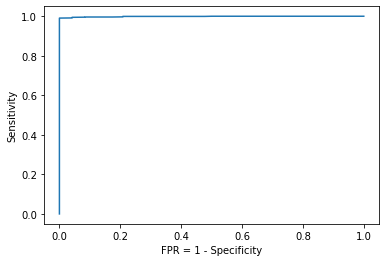

In [157]:
plt.plot(ROS_TABLE['FPR'], ROS_TABLE['Sensitivity'])
plt.xlabel('FPR = 1 - Specificity')
plt.ylabel('Sensitivity')
plt.savefig('../img/FDRvsSensitivity.jpeg', dpi = 100)

In [42]:
ROS_TABLE['Sensitivity'][1222]

0.9494949494949495

In [43]:
ROS_TABLE['Sensitivity'][1223]

0.9502719502719502

In [44]:
ROS_TABLE['Sensitivity'][600]

0.4662004662004662

In [45]:
treshold_index = ROS_TABLE['Sensitivity'].astype(float).sub(0.99).abs().idxmin()
print(treshold_index, ROS_TABLE['Sensitivity'][treshold_index], ROS_TABLE['Specificity'][treshold_index])

1274 0.98989898989899 1.0


In [46]:
ROS_TABLE['F1'] = 2*ROS_TABLE['TP']/(2*ROS_TABLE['TP']+ROS_TABLE['FP']+ROS_TABLE['FN'])

In [47]:
ROS_TABLE['F1']

0                0
1        0.0015528
2       0.00310318
3       0.00465116
4       0.00619675
           ...    
1307      0.992678
1308      0.992296
1309      0.991914
1310      0.991532
1311       0.99115
Name: F1, Length: 1312, dtype: object

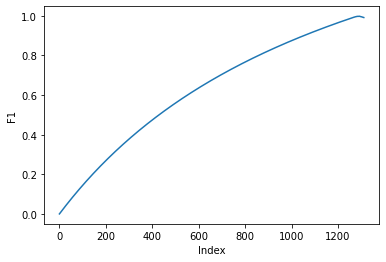

In [155]:
plt.plot(index, ROS_TABLE['F1'])
plt.xlabel('Index')
plt.ylabel('F1')
plt.savefig('../img/F1vsIndex.jpeg', dpi = 100)

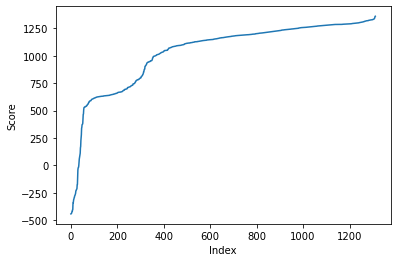

In [154]:
scores=from_table['Score'].sort_values(ascending=True, ignore_index=True)
plt.plot(scores)
plt.xlabel('Index')
plt.ylabel('Score')
plt.savefig('../img/ScoreVSindex.jpeg', dpi = 100)

In [160]:
treshold_max = ROS_TABLE['F1'].astype(float).idxmax()

In [149]:
treshold_max -= 20

In [150]:
_2x2 = pd.DataFrame(index=['Positive', 'Negative'], columns=['Positive', 'Negative'])

In [151]:
_2x2['Positive']['Positive'] = ROS_TABLE['TP'][treshold_max]
_2x2['Positive']['Negative'] = ROS_TABLE['FN'][treshold_max]
_2x2['Negative']['Positive'] = ROS_TABLE['FP'][treshold_max]
_2x2['Negative']['Negative'] = ROS_TABLE['TN'][treshold_max]

In [159]:
_2x2

,Positive,Negative
Positive,1272,0
Negative,15,24


In [162]:
from_table['Score'][1276]

37.3

In [129]:
_2x2

,Positive,Negative
Positive,1287,5
Negative,1,18


In [158]:
treshold_max

1272

In [161]:
ROS_TABLE[treshold_max-20:treshold_max+20]

,Sensitivity,Specificity,TN,TP,FP,FN,FPR,F1
1272,0.988345,1,24,1272,0,15,0,0.994138
1273,0.989122,1,24,1273,0,14,0,0.994531
1274,0.989899,1,24,1274,0,13,0,0.994924
1275,0.990676,1,24,1275,0,12,0,0.995316
1276,0.990683,1,23,1276,0,12,0,0.99532
1277,0.991453,0.958333,23,1276,1,11,0.0416667,0.99532
1278,0.99223,0.958333,23,1277,1,10,0.0416667,0.995712
1279,0.993007,0.958333,23,1278,1,9,0.0416667,0.996103
1280,0.993784,0.958333,23,1279,1,8,0.0416667,0.996494
1281,0.994561,0.958333,23,1280,1,7,0.0416667,0.996885


In [163]:
_2x2.to_html('2x2.html')